http://seananderson.ca/2013/10/19/reshape.html

# Tabular Data Gym 2. Reshaping.

In [186]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.style
matplotlib.style.use('ggplot')

%matplotlib inline

In [187]:
%load_ext rpy2.ipython

The rpy2.ipython extension is already loaded. To reload it, use:
  %reload_ext rpy2.ipython


In [188]:
%%R
library(magrittr)
library(ggplot2)
library(dplyr)
library(reshape2)

In [189]:
%%R
names(airquality) <- tolower(names(airquality))
head(airquality)

  ozone solar.r wind temp month day
1    41     190  7.4   67     5   1
2    36     118  8.0   72     5   2
3    12     149 12.6   74     5   3
4    18     313 11.5   62     5   4
5    NA      NA 14.3   56     5   5
6    28      NA 14.9   66     5   6


In [212]:
aq_pd = %R airquality
aq_pd.head()

,ozone,solar.r,wind,temp,month,day
1,41,190,7.4,67,5,1
2,36,118,8.0,72,5,2
3,12,149,12.6,74,5,3
4,18,313,11.5,62,5,4
5,-2147483648,-2147483648,14.3,56,5,5


Since `rpy2` does not treat NA well, we need to change it manually to `np.nan`.

In [191]:
def fix_nans_in_df(colname, df):
    df.ix[df[colname] < 0, colname] = np.NaN    

for colname in aq_pd.columns.values:
    fix_nans_in_df(colname, aq_pd)

aq_pd.head()

,ozone,solar.r,wind,temp,month,day
1,41,190,7.4,67,5,1
2,36,118,8.0,72,5,2
3,12,149,12.6,74,5,3
4,18,313,11.5,62,5,4
5,NaN,NaN,14.3,56,5,5


## Melt/stack: changing wide format into long

R function `melt` from `reshape2` package change wide fromat into long. 

In [192]:
%%R

aql <- melt(airquality)
aql %>% head

/home/bartek/venvs/py3.5/lib/python3.5/site-packages/rpy2/rinterface/__init__.py:185: RRuntimeWarning: No id variables; using all as measure variables

  warnings.warn(x, RRuntimeWarning)


  variable value
1    ozone    41
2    ozone    36
3    ozone    12
4    ozone    18
5    ozone    NA
6    ozone    28


### Question 1

One can get similar result using pandas' method `melt`. 

In [193]:
pd.melt(aq_pd).head()

,variable,value
0,ozone,41
1,ozone,36
2,ozone,12
3,ozone,18
4,ozone,NaN


### Question 2

In [194]:
%%R
airquality %>%
    melt(id.vars = c("month", "day")) %>%
    head()

  month day variable value
1     5   1    ozone    41
2     5   2    ozone    36
3     5   3    ozone    12
4     5   4    ozone    18
5     5   5    ozone    NA
6     5   6    ozone    28


Now let's try to get it with pandas.

In [195]:
pd.melt(aq_pd, id_vars=['month', 'day']).head()

,month,day,variable,value
0,5,1,ozone,41
1,5,2,ozone,36
2,5,3,ozone,12
3,5,4,ozone,18
4,5,5,ozone,NaN


## Question 3 Putting names to columns

In [196]:
%%R

aql <-
  melt(airquality, id.vars = c("month", "day"),
  variable.name = "climate_variable", 
  value.name = "climate_value") %>%
  mutate(date=as.Date(paste0("2015-",month,'-',day)))
head(aql)

  month day climate_variable climate_value       date
1     5   1            ozone            41 2015-05-01
2     5   2            ozone            36 2015-05-02
3     5   3            ozone            12 2015-05-03
4     5   4            ozone            18 2015-05-04
5     5   5            ozone            NA 2015-05-05
6     5   6            ozone            28 2015-05-06


Your turn with pandas.

In [197]:
aql_pd = \
    pd.melt(aq_pd, id_vars = ["month", "day"],
    var_name = "climate_variable", 
    value_name = "climate_value")

aql_pd.head()

,month,day,climate_variable,climate_value
0,5,1,ozone,41
1,5,2,ozone,36
2,5,3,ozone,12
3,5,4,ozone,18
4,5,5,ozone,NaN


### Comments about ploting

When one uses ggplot it is natural to use long format when ploting.

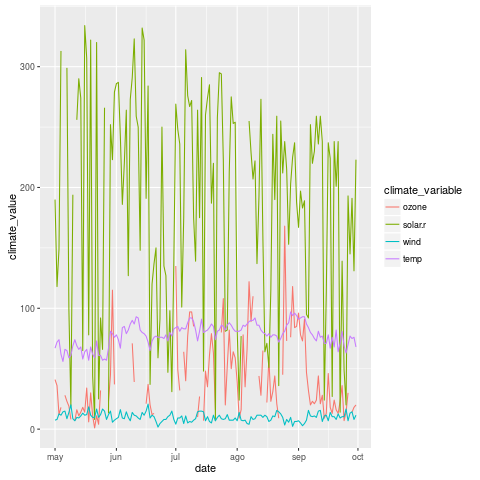

In [198]:
%%R
aql %>%
  ggplot() +
  geom_line(aes(date, climate_value, colour=climate_variable))

But with pandas' mathplotlib interface it is easier to use wild format.

First let's create dates.

In [199]:
aq_pd2= aq_pd.copy()

aq_pd2['date'] = \
    [pd.Timestamp(s) 
     for s in ('2015-'+aq_pd['month'].astype(int).astype(str)+'-'
               +aq_pd['day'].astype(int).astype(str))]

Then selecting columns and adding aproprite index one get: 

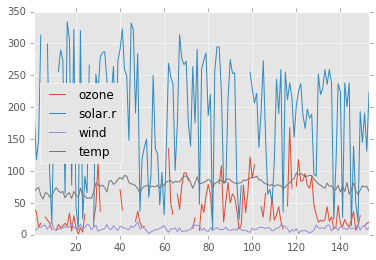

In [200]:
aq_pd2_indexed = aq_pd2[['date', 'ozone', 'solar.r', 'wind', 'temp']]
aq_pd2_indexed.set_index('date')
aq_pd2_indexed.plot()

## Long- to wide-format data

In [201]:
%%R
aql <- melt(airquality, id.vars = c("month", "day"))
head(aql)

  month day variable value
1     5   1    ozone    41
2     5   2    ozone    36
3     5   3    ozone    12
4     5   4    ozone    18
5     5   5    ozone    NA
6     5   6    ozone    28


In [202]:
aql_pd = pd.melt(aq_pd, id_vars = ["month", "day"])
#aql_pd.value=pd.to_numeric(aql_pd.value)
aql_pd.head()

,month,day,variable,value
0,5,1,ozone,41
1,5,2,ozone,36
2,5,3,ozone,12
3,5,4,ozone,18
4,5,5,ozone,NaN


### Question 4. Time for dcast

In [203]:
%%R
aqw <- dcast(aql, month + day ~ variable)
head(aqw)

  month day ozone solar.r wind temp
1     5   1    41     190  7.4   67
2     5   2    36     118  8.0   72
3     5   3    12     149 12.6   74
4     5   4    18     313 11.5   62
5     5   5    NA      NA 14.3   56
6     5   6    28      NA 14.9   66


The approprite pandas method seems to be `pivot_table`. Can you try?

In [204]:
aqw_pd = pd.pivot_table(aql_pd, values='value', index=['month', 'day'])

### Question 5. Melting with stack

There is another pandas' method for maelting. It is called stack. Can you try it with `aq_pd`? What is the type of the result? Can you make it to be DataFrame with comlumns `varaiable` and `value`?

In [205]:
aql_pd2=aq_pd.stack()
aql_pd2.head()

1  ozone       41.0
   solar.r    190.0
   wind         7.4
   temp        67.0
   month        5.0
dtype: float64

In [206]:
type(aql_pd2)

pandas.core.series.Series

In [207]:
aql_pd3 = aql_pd2.to_frame().reset_index(level=1)

In [208]:
aql_pd3.columns = ["variable", "value"]
aql_pd3.head()

,variable,value
1,ozone,41.0
1,solar.r,190.0
1,wind,7.4
1,temp,67.0
1,month,5.0


### Question 6. Melt, filter, group, agregate.

In [209]:
%%R
aql %>% head

  month day variable value
1     5   1    ozone    41
2     5   2    ozone    36
3     5   3    ozone    12
4     5   4    ozone    18
5     5   5    ozone    NA
6     5   6    ozone    28


In [214]:
%%R
airquality %>%
    melt(id.vars = c("month", "day")) %>%
    filter(!is.na(value)) %>%
    group_by(variable) %>%
    summarize(total= sum(value))  

# A tibble: 4 × 2
  variable   total
    <fctr>   <dbl>
1    ozone  4887.0
2  solar.r 27146.0
3     wind  1523.5
4     temp 11916.0


In [215]:
%%R
library(data.table)
data.table(airquality) %>%
    melt(id.vars = c("month", "day")) %>%
    .[!is.na(value), .(total=sum(value)), by=variable]

   variable   total
1:    ozone  4887.0
2:  solar.r 27146.0
3:     wind  1523.5
4:     temp 11916.0


Time for doing this with pands: